In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.plot import plot_summary_stats
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

2024-06-29 19:41:41,130|INFO|Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3(001)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
2024-06-29 19:41:41,256|INFO|Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
2024-06-29 19:41:41,258|INFO|Initializing 64 virtual atoms
2024-06-29 19:41:41,262|INFO|Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-29 19:41:41,263|INFO|Number of pristine atoms is 60
2024-06-29 19:41:41,267|INFO|Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
2024-06-29 19:41:41,268|INF

      Step     Time          Energy         fmax
BFGS:    0 19:41:41     -467.521881        0.2044
BFGS:    1 19:41:41     -467.525757        0.1803
BFGS:    2 19:41:41     -467.540619        0.0793
BFGS:    3 19:41:42     -467.540924        0.0598
BFGS:    4 19:41:42     -467.541351        0.0059


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

2024-06-29 19:41:42,332|INFO|Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
2024-06-29 19:41:42,333|INFO|There are 60 atoms in pristine slab
2024-06-29 19:41:42,334|INFO|Using user specified run folder SrTiO3(001)
2024-06-29 19:41:42,335|INFO|Starting with iteration 0
2024-06-29 19:41:42,336|INFO|Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
2024-06-29 19:41:42,336|INFO|In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:41:42     -470.650299        8.3206
BFGS:    1 19:41:42     -471.693878        5.7267
BFGS:    2 19:41:42     -472.726471        2.9446
BFGS:    3 19:41:42     -473.581879        2.7304
BFGS:    4 19:41:42     -474.031525        2.5585
BFGS:    5 19:41:42     -474.229828        2.2705
BFGS:    6 19:41:42     -474.636505        1.0711
BFGS:    7 19:41:43     -474.928558        1.7129
BFGS:    8 19:41:43     -475.291016        2.9809
BFGS:    9 19:41:43     -475.718842        2.9242
BFGS:   10 19:41:43     -476.132599        1.9062
BFGS:   11 19:41:43     -476.445282        1.2268
BFGS:   12 19:41:43     -476.505035        1.4672
BFGS:   13 19:41:43     -476.637177        1.1295
BFGS:   14 19:41:43     -476.847504        1.0265
BFGS:   15 19:41:43     -476.871704        1.0129
BFGS:   16 19:41:43     -477.009064        0.8778
BFGS:   17 19:41:43     -477.041382        0.8577
BFGS:   18 19:41:44     -477.146118        1.2038
B

2024-06-29 19:41:52,190|INFO|Optimized structure has Energy = 12.471
2024-06-29 19:41:52,206|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:41:52     -469.542145        5.6639
BFGS:    1 19:41:52     -470.062103        3.7482
BFGS:    2 19:41:52     -470.705658        1.5011
BFGS:    3 19:41:52     -470.950348        1.2638
BFGS:    4 19:41:52     -471.057770        1.3035
BFGS:    5 19:41:52     -471.338776        1.1571
BFGS:    6 19:41:52     -471.263184        1.6029
BFGS:    7 19:41:52     -471.440308        0.7621
BFGS:    8 19:41:53     -471.475616        0.6791
BFGS:    9 19:41:53     -471.533325        1.3139
BFGS:   10 19:41:53     -471.561890        0.7722
BFGS:   11 19:41:53     -471.598053        0.3217
BFGS:   12 19:41:53     -471.623383        0.3178
BFGS:   13 19:41:53     -471.630951        0.3097
BFGS:   14 19:41:53     -471.637604        0.2236
BFGS:   15 19:41:53     -471.642944        0.1895
BFGS:   16 19:41:53     -471.647736        0.1818
BFGS:   17 19:41:53     -471.650909        0.1953
BFGS:   18 19:41:53     -471.655060        0.1381
B

2024-06-29 19:42:02,459|INFO|Optimized structure has Energy = 10.700
2024-06-29 19:42:02,474|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:42:02     -481.178802       15.4268
BFGS:    1 19:42:02     -483.739838        3.5507
BFGS:    2 19:42:02     -484.554413        2.3863
BFGS:    3 19:42:02     -485.290405        1.6515
BFGS:    4 19:42:02     -485.478668        1.5613
BFGS:    5 19:42:03     -485.756592        1.3983
BFGS:    6 19:42:03     -485.901031        1.4299
BFGS:    7 19:42:03     -486.081299        1.5383
BFGS:    8 19:42:03     -486.252106        1.9274
BFGS:    9 19:42:03     -486.472565        1.5677
BFGS:   10 19:42:03     -486.648315        0.8951
BFGS:   11 19:42:03     -486.724396        0.6386
BFGS:   12 19:42:03     -486.779205        0.5907
BFGS:   13 19:42:03     -486.818512        0.5509
BFGS:   14 19:42:03     -486.839966        0.4565
BFGS:   15 19:42:04     -486.857910        0.4031
BFGS:   16 19:42:04     -486.876678        0.3927
BFGS:   17 19:42:04     -486.896149        0.4873
BFGS:   18 19:42:04     -486.908569        0.3038
B

2024-06-29 19:42:13,270|INFO|Optimized structure has Energy = 9.979
2024-06-29 19:42:13,283|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:42:13     -426.085114      122.1703
BFGS:    1 19:42:13     -456.051605       44.3767
BFGS:    2 19:42:13     -471.528229       29.5635
BFGS:    3 19:42:13     -480.352692       18.4952
BFGS:    4 19:42:13     -486.070160       10.4865
BFGS:    5 19:42:13     -489.772095        7.9914
BFGS:    6 19:42:13     -492.256348        5.5502
BFGS:    7 19:42:14     -493.920868        4.0524
BFGS:    8 19:42:14     -495.026978        2.8127
BFGS:    9 19:42:14     -495.614105        2.8572
BFGS:   10 19:42:14     -495.970490        2.9935
BFGS:   11 19:42:14     -496.886078        2.9690
BFGS:   12 19:42:14     -497.423187        3.0305
BFGS:   13 19:42:14     -497.949615        2.6002
BFGS:   14 19:42:14     -498.299652        2.0269
BFGS:   15 19:42:14     -498.658539        1.8866
BFGS:   16 19:42:14     -499.141937        2.5934
BFGS:   17 19:42:14     -499.563599        2.4046
BFGS:   18 19:42:14     -499.654877        4.7938
B

2024-06-29 19:42:23,660|INFO|Optimized structure has Energy = 12.013
2024-06-29 19:42:23,674|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:42:23     -419.413116      138.5648
BFGS:    1 19:42:23     -448.040497       36.8599
BFGS:    2 19:42:23     -462.901886       28.5497
BFGS:    3 19:42:24     -464.101532       33.1535
BFGS:    4 19:42:24     -481.858795       42.7338
BFGS:    5 19:42:24     -491.261597       18.6594
BFGS:    6 19:42:24     -496.607513        7.9298
BFGS:    7 19:42:24     -499.675171        2.9175
BFGS:    8 19:42:24     -501.307587        2.8438
BFGS:    9 19:42:24     -502.543732        4.2698
BFGS:   10 19:42:24     -503.615692        5.9465
BFGS:   11 19:42:24     -504.571930        3.9105
BFGS:   12 19:42:24     -505.996002        3.4657
BFGS:   13 19:42:25     -506.441498        2.7746
BFGS:   14 19:42:25     -507.118134        2.7805
BFGS:   15 19:42:25     -507.863312        2.7524
BFGS:   16 19:42:25     -508.517212        2.9322
BFGS:   17 19:42:25     -509.060211        2.7063
BFGS:   18 19:42:25     -509.523926        2.5226
B

2024-06-29 19:42:34,089|INFO|Optimized structure has Energy = 4.554
2024-06-29 19:42:34,105|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:42:34     -412.846680      138.2909
BFGS:    1 19:42:34     -444.789703       36.7577
BFGS:    2 19:42:34     -461.673340       53.1052
BFGS:    3 19:42:34     -448.442535      503.8027
BFGS:    4 19:42:34     -479.127472      116.9602
BFGS:    5 19:42:34     -486.036957       46.3967
BFGS:    6 19:42:34     -490.698395       11.3997
BFGS:    7 19:42:34     -492.438446       12.6698
BFGS:    8 19:42:34     -493.456787        4.1615
BFGS:    9 19:42:34     -494.534668        4.9984
BFGS:   10 19:42:35     -495.008942        4.0320
BFGS:   11 19:42:35     -495.553009        8.1208
BFGS:   12 19:42:35     -495.808716        6.4406
BFGS:   13 19:42:35     -496.086578        3.1502
BFGS:   14 19:42:35     -496.402466        4.8010
BFGS:   15 19:42:35     -496.688568        4.8964
BFGS:   16 19:42:35     -496.929596        2.2023
BFGS:   17 19:42:35     -497.254547        5.7662
BFGS:   18 19:42:35     -497.462372        5.5704
B

2024-06-29 19:42:44,241|INFO|Optimized structure has Energy = 4.554
2024-06-29 19:42:44,254|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:42:44     -426.228119      137.4525
BFGS:    1 19:42:44     -454.938141       36.2228
BFGS:    2 19:42:44     -470.654053       27.3542
BFGS:    3 19:42:44     -476.711639       59.4743
BFGS:    4 19:42:44     -488.638031       48.7075
BFGS:    5 19:42:44     -489.862885      131.3040
BFGS:    6 19:42:44     -497.225372        7.3856
BFGS:    7 19:42:44     -499.318024       14.5896
BFGS:    8 19:42:45     -501.051239       16.2812
BFGS:    9 19:42:45     -502.731567       16.8658
BFGS:   10 19:42:45     -503.879181        7.3720
BFGS:   11 19:42:45     -504.886597        2.5420
BFGS:   12 19:42:45     -505.964691        2.9713
BFGS:   13 19:42:45     -506.596222       11.2142
BFGS:   14 19:42:45     -507.677765        9.0881
BFGS:   15 19:42:45     -508.546753        8.0393
BFGS:   16 19:42:45     -508.930664        9.2942
BFGS:   17 19:42:45     -509.194183       11.9247
BFGS:   18 19:42:45     -509.453979        6.8006
B

2024-06-29 19:42:54,258|INFO|Optimized structure has Energy = 4.554
2024-06-29 19:42:54,270|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:42:54     -421.618408      138.1328
BFGS:    1 19:42:54     -455.135498       36.8008
BFGS:    2 19:42:54     -471.023438       73.2690
BFGS:    3 19:42:54     -472.801910      249.7561
BFGS:    4 19:42:54     -491.450104       47.3949
BFGS:    5 19:42:54     -496.712769       32.1787
BFGS:    6 19:42:54     -500.222565        8.7861
BFGS:    7 19:42:55     -502.165680       15.9578
BFGS:    8 19:42:55     -503.391724        4.7480
BFGS:    9 19:42:55     -504.602936        5.8750
BFGS:   10 19:42:55     -505.719513        2.4284
BFGS:   11 19:42:55     -506.117340        2.2944
BFGS:   12 19:42:55     -506.811127        6.8881
BFGS:   13 19:42:55     -507.103912        5.9498
BFGS:   14 19:42:55     -507.670258        4.2666
BFGS:   15 19:42:55     -507.897339        2.0936
BFGS:   16 19:42:55     -508.141846        1.8808
BFGS:   17 19:42:55     -508.490082        3.6003
BFGS:   18 19:42:56     -508.718506        1.9428
B

2024-06-29 19:43:03,638|INFO|Optimized structure has Energy = -2.240
2024-06-29 19:43:03,658|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:43:03     -391.997467      138.0300
BFGS:    1 19:43:03     -412.645660      327.6194
BFGS:    2 19:43:03     -432.972412       60.9944
BFGS:    3 19:43:04     -452.346100      107.8019
BFGS:    4 19:43:04     -457.832977       70.9149
BFGS:    5 19:43:04     -470.020386       67.8786
BFGS:    6 19:43:04     -478.877045       42.7132
BFGS:    7 19:43:04     -482.910645       20.7546
BFGS:    8 19:43:04     -485.097015        7.5188
BFGS:    9 19:43:04     -486.099884       20.5323
BFGS:   10 19:43:04     -487.146881        4.8723
BFGS:   11 19:43:04     -488.060333       21.8054
BFGS:   12 19:43:04     -488.917572        6.5304
BFGS:   13 19:43:04     -489.423126       10.6525
BFGS:   14 19:43:04     -489.795288        8.0688
BFGS:   15 19:43:04     -490.703522       22.1710
BFGS:   16 19:43:05     -491.527496       13.7430
BFGS:   17 19:43:05     -492.039429        5.1528
BFGS:   18 19:43:05     -492.524261       10.2346
B

2024-06-29 19:43:13,586|INFO|Optimized structure has Energy = -1.759
2024-06-29 19:43:13,603|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 19:43:13     -155.096390     4041.9962
BFGS:    1 19:43:13     -391.954224      129.5023
BFGS:    2 19:43:13     -421.118896       47.7513
BFGS:    3 19:43:13     -432.511749       68.0946
BFGS:    4 19:43:14     -458.525543       45.4240
BFGS:    5 19:43:14     -473.444977       48.1852
BFGS:    6 19:43:14     -482.318359       53.0762
BFGS:    7 19:43:14     -488.293610       58.5342
BFGS:    8 19:43:14     -492.236664       61.8401
BFGS:    9 19:43:14     -494.859894       60.1840
BFGS:   10 19:43:14     -496.358643       45.6196
BFGS:   11 19:43:14     -497.999298       28.4520
BFGS:   12 19:43:14     -499.266632       16.9893
BFGS:   13 19:43:14     -500.007660        3.5953
BFGS:   14 19:43:14     -500.551361       37.1996
BFGS:   15 19:43:15     -501.400055        5.7653
BFGS:   16 19:43:15     -502.082733        6.5356
BFGS:   17 19:43:15     -503.114166        2.7823
BFGS:   18 19:43:15     -503.692535        4.7951
B

2024-06-29 19:43:24,419|INFO|Optimized structure has Energy = -1.622


Time taken = 102.102 seconds


Plot results

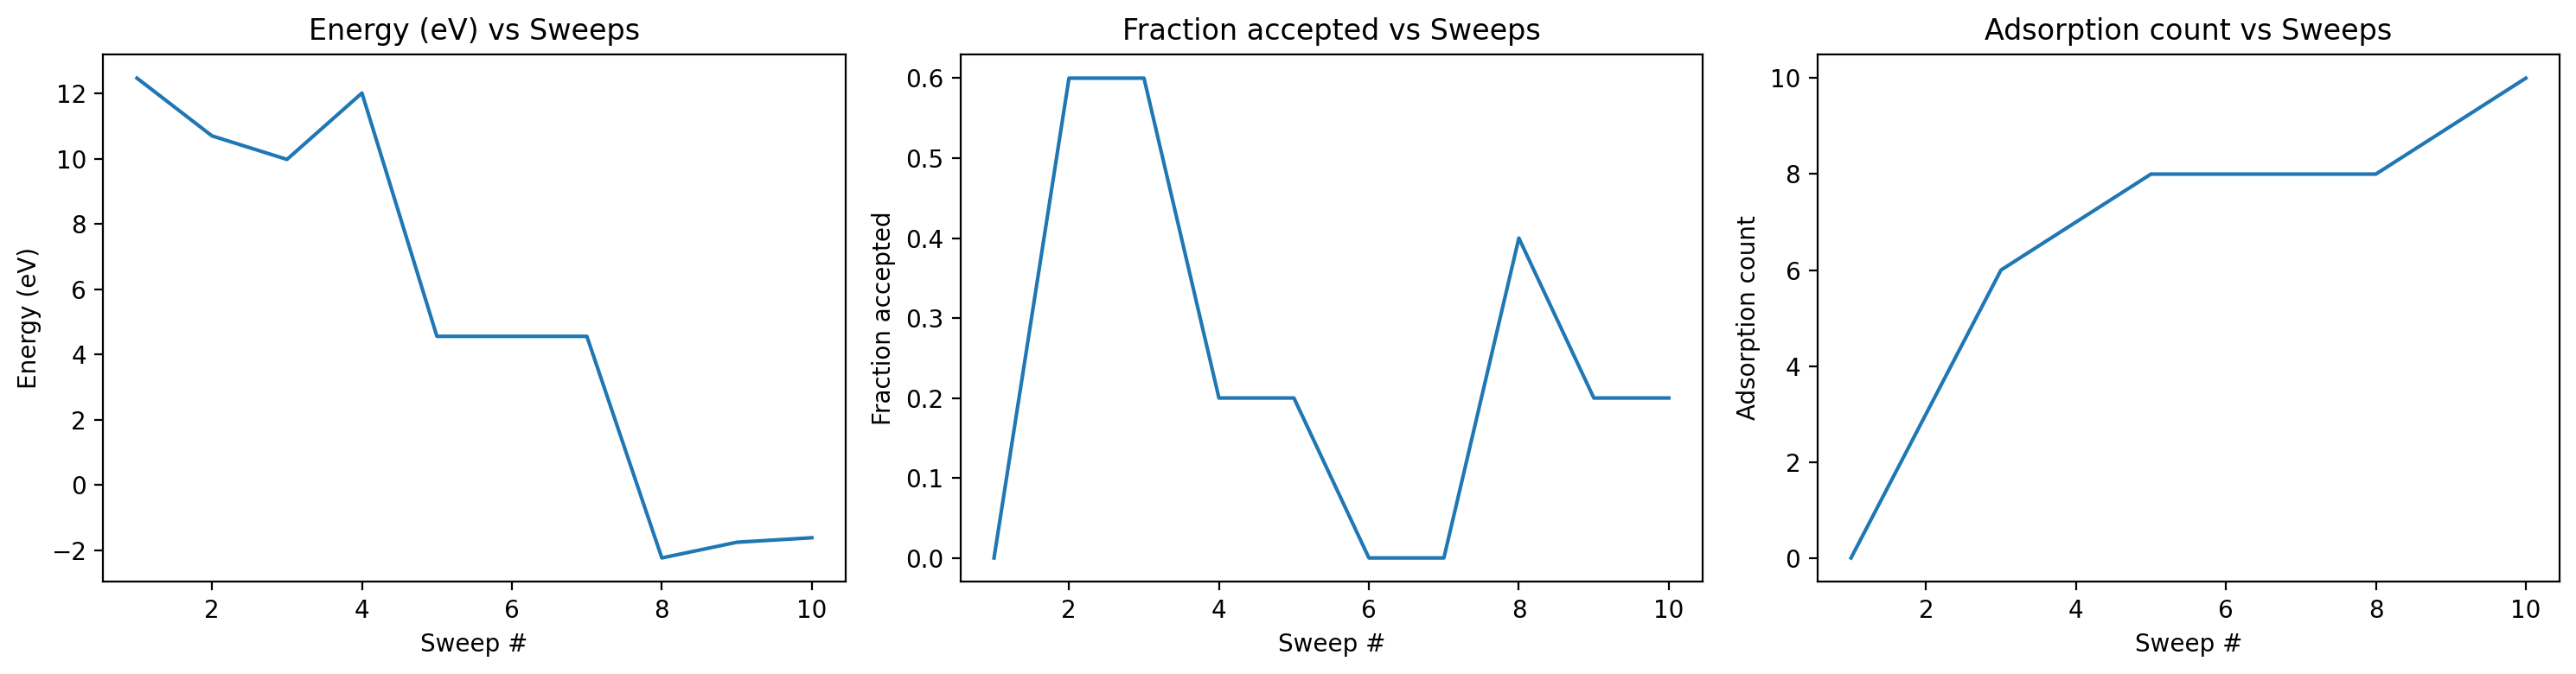

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)